In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.transforms import ToTensor

## Классификация предметов одежды (датасет Fashion MNIST)


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA доступна")
else:
    device = torch.device("cpu")
    print("CUDA недоступна, используется CPU")


CUDA доступна


In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15965328.64it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273285.73it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4974523.47it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19091314.76it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
for img, y in train_dataloader:
  print(img[0].shape)
  display(img[0][0][0])
  break

torch.Size([1, 28, 28])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

img_size = 28

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


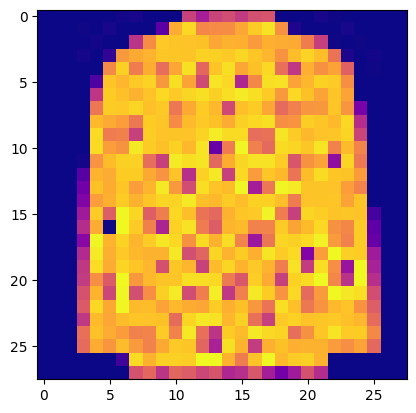

Label: Pullover


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='plasma')
plt.show()
print(f"Label: {labels_map[label.item()]}")

In [ ]:
def fit(dataloader, *, model, criterion, num_epochs, lr):
  for layer in  model.modules():
    if isinstance(layer, nn.Linear):
      nn.init.xavier_uniform_(layer.weight)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  total_step = len(dataloader)
  losses = []
  for epoch in range(num_epochs):
    correct = 0
    total = 0
    for images, labels in dataloader:
      images = images.to(device)
      images = images
      labels = labels.to(device)

      # Forwarde
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Вычисление accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    losses.append(loss.cpu().detach().numpy())
    print(f"Epoch: {epoch+1}/{num_epochs} - loss: {losses[-1]:.4} - accuracy: {(correct / total):.4}")
  return model, losses

Изначально попробуем без CNN. Так как изображения 28 на 28 пикселей, то возбмем 3 обычных dense слоя из 128 64 и 10 соответсвенно нейронов, после каждого Danse кроме последнего идет ReLU(). Для борьбы с переобучением и ради эксперементов добавим Dropout() с вероятностью 0.2 и 0.5

In [ ]:
model = nn.Sequential(
    nn.BatchNorm1d(28),
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 10)
).to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
# .numel() возвращает общее количество элементов в тензоре
sum(p.numel() for p in model.parameters())

109442

In [ ]:
fit_model, losses = fit(train_dataloader, model=model, criterion=criterion,
                num_epochs=10, lr=0.01)

Epoch: 1/10 - loss: 0.5249 - accuracy: 0.746
Epoch: 2/10 - loss: 0.5364 - accuracy: 0.8063
Epoch: 3/10 - loss: 0.3194 - accuracy: 0.8154
Epoch: 4/10 - loss: 0.8499 - accuracy: 0.8168
Epoch: 5/10 - loss: 0.4519 - accuracy: 0.8199
Epoch: 6/10 - loss: 0.7656 - accuracy: 0.8225
Epoch: 7/10 - loss: 0.2911 - accuracy: 0.8209
Epoch: 8/10 - loss: 0.4967 - accuracy: 0.826
Epoch: 9/10 - loss: 0.8807 - accuracy: 0.8229
Epoch: 10/10 - loss: 0.5091 - accuracy: 0.8258


Выведем график функции потерь по эпохам.

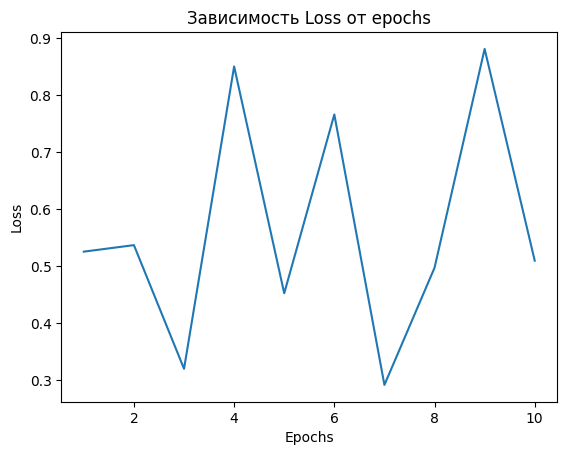

In [ ]:
plt.plot(range(1, 11), losses)
plt.title("Зависимость Loss от epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Используем тестовое множество

In [ ]:
model.load_state_dict(torch.load('model.pt'))
model.eval() # Переключине в режим без обучения, чтобы исключить Dropout()
print("Данные загружены")

Данные загружены


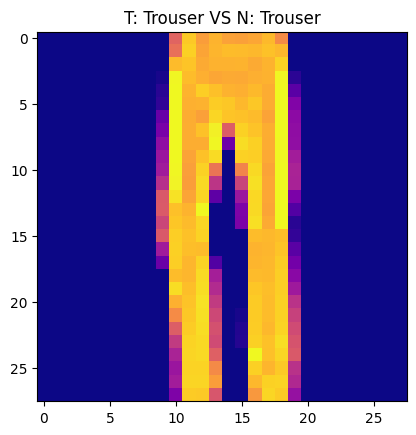

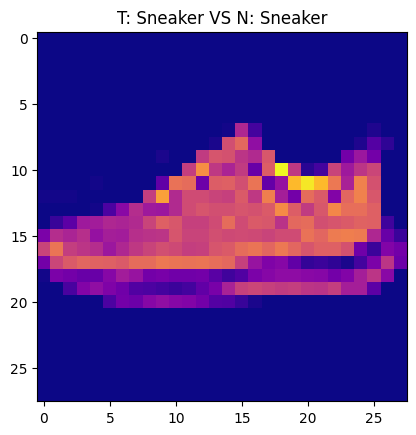

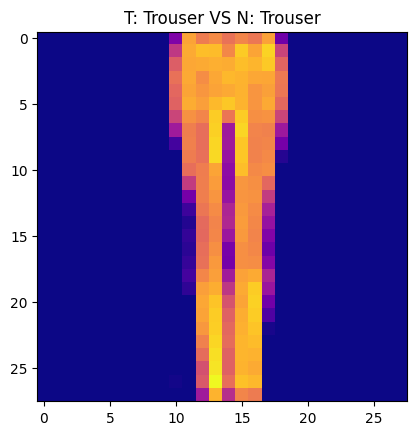

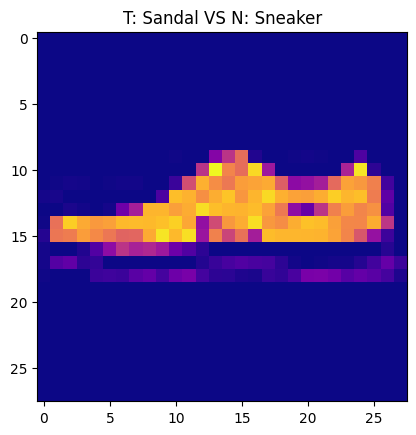

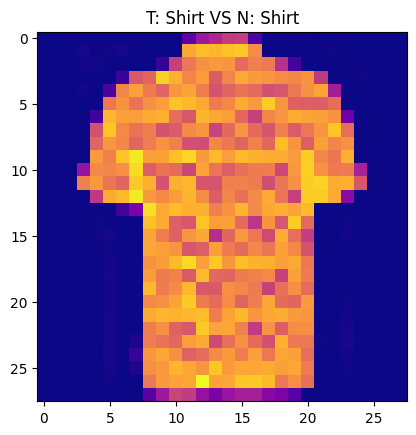

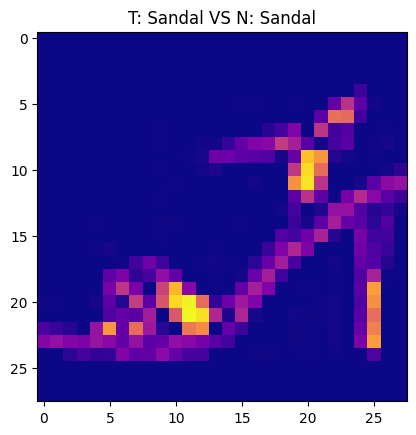

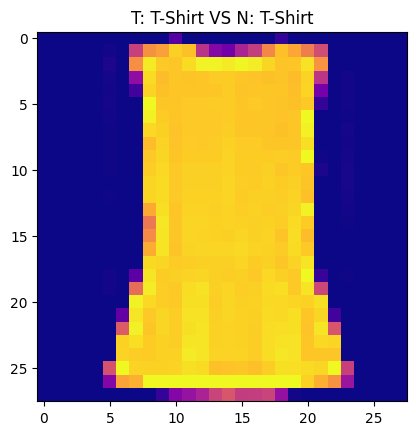

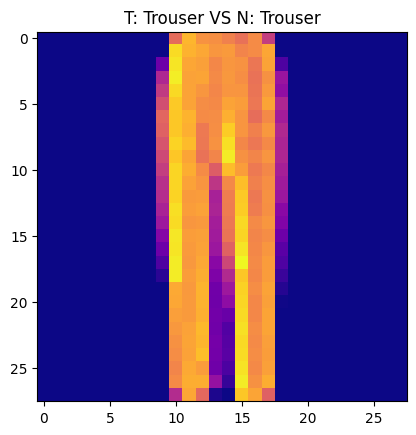

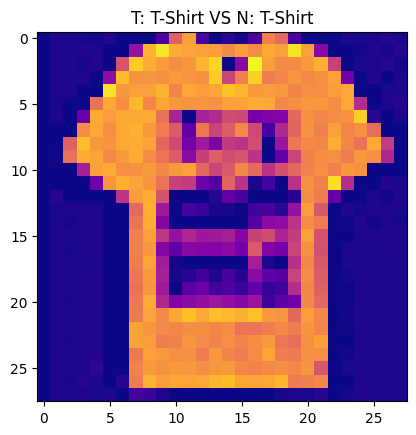

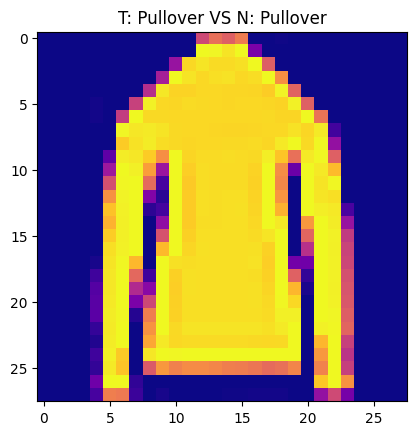

In [ ]:
# Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.
test_features, test_labels = next(iter(test_dataloader))

for i in range(10):
  img = test_features[i].to(device)
  label = test_labels[i].to(device)
  predict = model(img).data
  _, predicted = torch.max(predict, 1)
  plt.imshow(img.cpu().squeeze(), cmap='plasma')
  plt.title(f"T: {labels_map[label.item()]} VS N: {labels_map[predicted.item()]}")
  plt.show()

In [ ]:
predictions = []
true_labels = []
for images, labels in test_dataloader:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images.squeeze())
  true_labels.extend(labels.cpu().detach().numpy())
  _, predicted = torch.max(outputs.data, 1)
  predictions.extend(predicted.tolist())

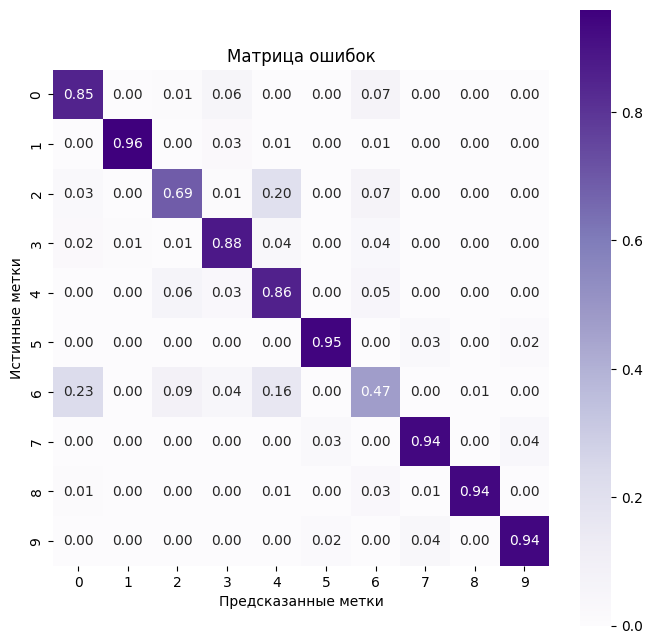

In [ ]:
# Вывводим матрицу ощибок
import seaborn as sns
import numpy as np

confusion_matrix = np.zeros((10, 10))
for true_label, predicted in zip(true_labels, predictions):
  confusion_matrix[true_label][predicted] += 1

confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Purples', fmt='.2f', square=True)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
# Выводим значение accuracy на тестовом множестве.
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predictions)
print(f"val-score: {accuracy:.4}")

val-score: 0.8471


Хорошие результаты, но нужно посмотреть, что будет с CNN

Сохраним модель

In [ ]:
torch.save(model.state_dict(), 'model.pt')

Используем CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxp1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.maxp1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.maxp2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
import numpy as np

def fit(dataloader, *, model, criterion, num_epochs, lr):
  # Инициализация весов с помощью Xavier
  for layer in  model.modules():
    if isinstance(layer, nn.Linear):
      nn.init.xavier_uniform_(layer.weight)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  total_step = len(dataloader)
  losses = []
  for epoch in range(num_epochs):
    correct = 0
    total = 0
    for images, labels in dataloader:
      epoch_loss = np.array([])

      images = images.to(device)
      labels = labels.to(device)

      # Прямой проход
      outputs = model(images)
      loss = criterion(outputs, labels)
      epoch_loss = np.append(epoch_loss, loss.cpu().detach().numpy())

      # Обратное распространение и оптимизация
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Вычисление accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    losses.append(np.mean(epoch_loss))
    if losses[-1] == min(losses):
      torch.save(model.state_dict(), 'best.pt')

    print(f"Epoch: {epoch+1}/{num_epochs} - loss: {losses[-1]:.4} - accuracy: {(correct / total):.4}")
  return model, losses

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
fit_model, losses = fit(train_dataloader, model=model, criterion=criterion,
                num_epochs=15, lr=0.01)

Epoch: 1/15 - loss: 0.2308 - accuracy: 0.8554
Epoch: 2/15 - loss: 0.1542 - accuracy: 0.898
Epoch: 3/15 - loss: 0.2534 - accuracy: 0.9077
Epoch: 4/15 - loss: 0.3975 - accuracy: 0.9142
Epoch: 5/15 - loss: 0.1673 - accuracy: 0.9172
Epoch: 6/15 - loss: 0.3732 - accuracy: 0.9207
Epoch: 7/15 - loss: 0.2892 - accuracy: 0.9243
Epoch: 8/15 - loss: 0.03711 - accuracy: 0.9264
Epoch: 9/15 - loss: 0.1682 - accuracy: 0.9289
Epoch: 10/15 - loss: 0.2827 - accuracy: 0.9311
Epoch: 11/15 - loss: 0.1232 - accuracy: 0.9338
Epoch: 12/15 - loss: 0.5552 - accuracy: 0.9358
Epoch: 13/15 - loss: 0.2806 - accuracy: 0.9373
Epoch: 14/15 - loss: 0.3335 - accuracy: 0.9385
Epoch: 15/15 - loss: 0.3705 - accuracy: 0.9385


In [ ]:
model.load_state_dict(torch.load('best.pt'))
model.eval() # Переключине в режим без обучения, чтобы исключить Dropout()
print("Данные загружены")

Данные загружены


In [ ]:
predictions = []
true_labels = []
for images, labels in test_dataloader:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  true_labels.extend(labels.cpu().detach().numpy())
  _, predicted = torch.max(outputs.data, 1)
  predictions.extend(predicted.tolist())

In [ ]:
# Выводим значение accuracy на тестовом множестве.
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predictions)
print(f"val-score: {accuracy:.4}")

val-score: 0.9066


Точность улучшилась на 6 процентов, по сравнению с сеткой без CNN